
## 악플 분류기

# 데이터 소개

가설: 

악플 관련 단어들을 학습시키면 테스트데이터에서 어느 정도 구분해 낼 수 있을 것이다. 

1개 항목만 체크된 댓글보다 2개 이상이 악플이 더 많을 것이다.

댓글의 길이가 길수록 악플일 가능성이 높을 것이다?


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install squarify
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import  stopwords
import string
import re
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import squarify

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

train = pd.read_csv('/content/drive/MyDrive/dataset/comments/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/comments/test.csv')
print(train.shape, test.shape)
train.head()

(159571, 8) (153164, 2)


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
#결측치 확인
print(train.isnull().sum())
print(test.isnull().sum())

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64
id              0
comment_text    0
dtype: int64


In [ ]:
#불필요한 컬럼 드롭
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

In [ ]:
test.describe()

,comment_text
count,153164
unique,153164
top,. \n\n Sometimes even Car and Driver optimize...
freq,1


In [ ]:
train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print("malignant(악의있는):")
print(train[train.malignant==1].iloc[1,1])
#print(train[train.severe_toxic==1].iloc[5,1])

malignant(악의있는):
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [ ]:
print("highly_malignant(매우 악의있는):")
print(train[train.highly_malignant==1].iloc[1,1])
#print(train[train.highly_malignant==1].iloc[5,1])

highly_malignant(매우 악의있는):
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [ ]:
print("loathe(증오,혐오):")
print(train[train.loathe==1].iloc[1,1])
#print(train[train.loathe==1].iloc[5,1])

loathe(증오,혐오):
A pair of jew-hating weiner nazi schmucks.


In [ ]:
print("rude(무례한):")
print(train[train.rude==1].iloc[1,1])
#print(train[train.rude==1].iloc[5,1])

rude(무례한):
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [ ]:
print("abuse(욕설):")
print(train[train.abuse==1].iloc[1,1])
#print(train[train.abuse==1].iloc[5,1])

abuse(욕설):
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [ ]:
print("threat(협박):")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[5,1])

threat(협박):
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [ ]:
col=['malignant','highly_malignant','loathe','rude','abuse','threat']
for i in col:
    print(i)
    print(train[i].value_counts())

malignant
0    144277
1     15294
Name: malignant, dtype: int64
highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64
loathe
0    158166
1      1405
Name: loathe, dtype: int64
rude
0    151122
1      8449
Name: rude, dtype: int64
abuse
0    151694
1      7877
Name: abuse, dtype: int64
threat
0    159093
1       478
Name: threat, dtype: int64


# **전처리**

In [5]:
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)  
nltk.download('stopwords')
nltk.download('wordnet')

train['comment_text2'] = train['comment_text'].str.lower()#.split()
train['comment_text2'] = train['comment_text2'].str.replace(r"[^a-zA-Z0-9 ]", "")

train['comment_text2'] = train['comment_text2'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in string.punctuation))

stop_words = set(stopwords.words('english') +  ['will','wikipedia','going','u', 'ü', 'ur', 'im', 'dont', 'doin', 'ure','you',"don't",'people','know', "can't", 'sir', 'username', "i'm", "it's", 'it.', 'the', 'this'])
train['comment_text2'] = train['comment_text2'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

lem=WordNetLemmatizer()
train['comment_text2'] = train['comment_text2'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))
    


test['comment_text2'] = test['comment_text'].str.lower()#.split()
test['comment_text2'] = test['comment_text2'].str.replace(r"[^a-zA-Z0-9 ]", "")

test['comment_text2'] = test['comment_text2'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in string.punctuation))

stop_words = set(stopwords.words('english') +  ['will','wikipedia','going','u', 'ü', 'ur', 'im', 'dont', 'doin', 'ure','you',"don't",'people','know', "can't", 'sir', 'username', "i'm", "it's", 'it.', 'the', 'this'])
test['comment_text2'] = test['comment_text2'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

lem=WordNetLemmatizer()
test['comment_text2'] = test['comment_text2'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
test.head()

,id,comment_text,comment_text2
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful youll ever whats ha...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",look back source information updated correct f...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article


In [6]:
train['text_length'] = train.comment_text2.str.len()
train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_text2,text_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanationwhy edits made hardcore metallica f...,170
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww match background colour seemingly stuck t...,81
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...,141
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,morei cant make real suggestion improvement wo...,379
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,hero chance remember page thats,31


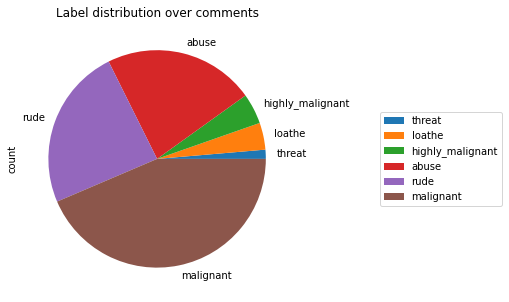

In [5]:
cols_target = ['malignant','highly_malignant','rude','threat','abuse','loathe']
df_distribution = train[cols_target].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y='count',
                                      title='Label distribution over comments',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [ ]:
train['comment_text2'].str.split()

0         [explanationwhy, edits, made, hardcore, metall...
1         [daww, match, background, colour, seemingly, s...
2         [hey, man, really, trying, edit, war, guy, con...
3         [morei, cant, make, real, suggestion, improvem...
4                     [hero, chance, remember, page, thats]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567    [ashamed, horrible, thing, put, talk, page, 12...
159568    [spitzer, umm, there, actual, article, prostit...
159569    [look, like, actually, put, speedy, first, ver...
159570    [really, think, understand, came, idea, bad, r...
Name: comment_text2, Length: 159571, dtype: object

In [1]:
target_data = train[cols_target]

train['bad'] =train[cols_target].sum(axis =1)
print(train['bad'].value_counts())
train['bad'] = train['bad'] > 0   #라벨링안되있으면 False 라벨링되있으면 True
train['bad'] = train['bad'].astype(int)  #라벨링안되있으면 0 라벨링되있으면 1
print(train['bad'].value_counts())
train['bad'] 


NameError: ignored

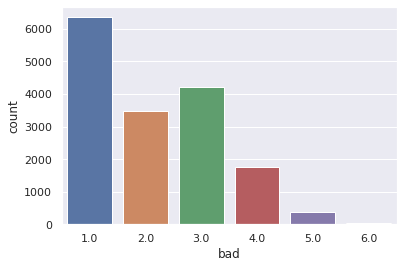

In [18]:
sns.set()
sns.countplot(x="bad" , data = train)
plt.show()

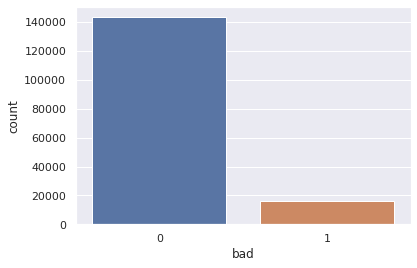

In [ ]:
sns.set()
sns.countplot(x="bad" , data = train)
plt.show()

In [ ]:
A = train['text_length'][train['bad']==1]
B = train['text_length'][train['bad']==0]
print(A.mean())
print(B.mean())

189.67346687211094
252.9753951976337


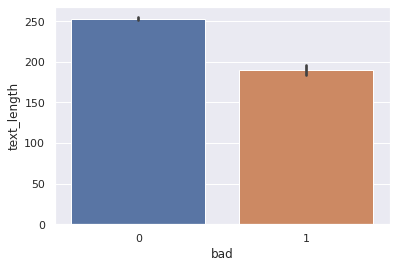

In [ ]:
sns.set()
sns.barplot(
    data= train,
    x= "bad",
    y= 'text_length'
)
plt.show()

In [5]:
tf_vec = TfidfVectorizer(max_features = 1000, stop_words='english')
features = tf_vec.fit_transform(train['comment_text2'])
features = pd.DataFrame(features.todense(), columns=tf_vec.get_feature_names())
features

,10,100,11,12,14,15,20,2004,2005,2006,2007,2008,2009,2010,2011,2012,24,25,30,able,absolutely,abuse,academic,accept,acceptable,accepted,access,according,account,accurate,accusation,act,action,active,activity,actual,actually,add,added,adding,...,welcome,went,west,western,whats,white,wiki,wikipedian,wikipedians,wikipedias,wikiproject,willing,wish,woman,wonder,wondering,wont,word,wording,work,worked,working,world,worth,wouldnt,wp,write,writer,writing,written,wrong,wrote,yeah,year,yes,york,youd,youll,youre,youve
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436468,0.0,0.0,0.0,0.0
1,0.0,0.0,0.491203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283059,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
159567,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
159568,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916304,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
159569,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.349026,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [6]:
from sklearn.neighbors import NearestNeighbors

# dtm을 사용히 NN 모델을 학습시킵니다. (디폴트)최근접 5 이웃.
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(features)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
print(train['comment_text2'][2][:300])
print(train['comment_text2'][7278][:300])

In [ ]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use


list_sentences_train = train["comment_text2"].values
list_sentences_test = test["comment_text2"].values
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
x = pad_sequences(list_tokenized_train, maxlen=maxlen)
y=train['bad']
x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.20)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((127656, 100), (127656,), (31915, 100), (31915,))

# 모델링 - 나쁜 댓글('bad') 분류하기

In [ ]:
import tensorflow as tf
vocab_size = 20000
embedding_dim = 16
max_length = 100

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 16)           320000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 9606      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 329,613
Trainable params: 329,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model = model.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val))

Epoch 1/10
3990/3990 [==============================] - 24s 6ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.4170 - val_accuracy: 0.9408
Epoch 2/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.4412 - val_accuracy: 0.9394
Epoch 3/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.4479 - val_accuracy: 0.9354
Epoch 4/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.4699 - val_accuracy: 0.9329
Epoch 5/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.5200 - val_accuracy: 0.9393
Epoch 6/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.5576 - val_accuracy: 0.9329
Epoch 7/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0052 - accuracy: 0.9980 - val_loss: 0.5900 - val_ac

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model = model.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val))

Epoch 1/10
3990/3990 [==============================] - 20s 5ms/step - loss: 0.1600 - accuracy: 0.9450 - val_loss: 0.1263 - val_accuracy: 0.9555
Epoch 2/10
3990/3990 [==============================] - 19s 5ms/step - loss: 0.0979 - accuracy: 0.9646 - val_loss: 0.1302 - val_accuracy: 0.9569
Epoch 3/10
3990/3990 [==============================] - 19s 5ms/step - loss: 0.0675 - accuracy: 0.9758 - val_loss: 0.1542 - val_accuracy: 0.9558
Epoch 4/10
3990/3990 [==============================] - 18s 5ms/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.1947 - val_accuracy: 0.9545
Epoch 5/10
3990/3990 [==============================] - 19s 5ms/step - loss: 0.0252 - accuracy: 0.9918 - val_loss: 0.2314 - val_accuracy: 0.9512
Epoch 6/10
3990/3990 [==============================] - 19s 5ms/step - loss: 0.0179 - accuracy: 0.9945 - val_loss: 0.2588 - val_accuracy: 0.9478
Epoch 7/10
3990/3990 [==============================] - 19s 5ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.3023 - val_ac

In [ ]:
print(model.history['loss'])
print(model.history['accuracy'])
print(model.history['val_loss'])
print(model.history['val_accuracy'])

[0.009549233131110668, 0.007460958790034056, 0.006861097179353237, 0.006449890788644552, 0.005908411927521229, 0.005656575318425894, 0.005152500234544277, 0.005016685929149389, 0.0046934871934354305, 0.004545758944004774]
[0.9968900680541992, 0.9975637793540955, 0.9976891279220581, 0.9977204203605652, 0.9978066086769104, 0.9980024695396423, 0.9980494379997253, 0.9980964660644531, 0.9981904625892639, 0.9983392953872681]
[0.41703155636787415, 0.4412327706813812, 0.4478943347930908, 0.4698815941810608, 0.5199998021125793, 0.55758136510849, 0.5899742245674133, 0.616977870464325, 0.6318735480308533, 0.6714370846748352]
[0.9408115148544312, 0.9394015073776245, 0.935359537601471, 0.9328842163085938, 0.9393388628959656, 0.9329155683517456, 0.9359862208366394, 0.928058922290802, 0.9333541989326477, 0.934482216835022]


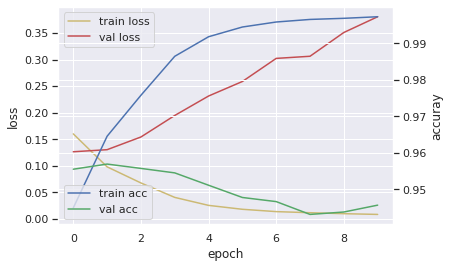

In [ ]:
# 5. 모델 학습 과정 표시하기 model
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(model.history['loss'], 'y', label='train loss')
loss_ax.plot(model.history['val_loss'], 'r', label='val loss')

acc_ax.plot(model.history['accuracy'], 'b', label='train acc')
acc_ax.plot(model.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),#(10000, embedding_dim, input_length=max_length),
  tf.keras.layers.LSTM(50, dropout=0.1, recurrent_dropout=0.1),# return_sequences=True,
  tf.keras.layers.Flatten(),#GlobalMaxPool1D(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 16)           320000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                13400     
_________________________________________________________________
flatten_10 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 306       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 7         
Total params: 333,713
Trainable params: 333,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2 = model2.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val))

Epoch 1/5
3990/3990 [==============================] - 500s 125ms/step - loss: 0.1414 - accuracy: 0.9515 - val_loss: 0.1068 - val_accuracy: 0.9624
Epoch 2/5
3990/3990 [==============================] - 497s 125ms/step - loss: 0.0960 - accuracy: 0.9643 - val_loss: 0.1069 - val_accuracy: 0.9618
Epoch 3/5
3990/3990 [==============================] - 496s 124ms/step - loss: 0.0842 - accuracy: 0.9677 - val_loss: 0.1084 - val_accuracy: 0.9626
Epoch 4/5
3990/3990 [==============================] - 498s 125ms/step - loss: 0.0732 - accuracy: 0.9720 - val_loss: 0.1225 - val_accuracy: 0.9595
Epoch 5/5
3990/3990 [==============================] - 496s 124ms/step - loss: 0.0639 - accuracy: 0.9754 - val_loss: 0.1235 - val_accuracy: 0.9588


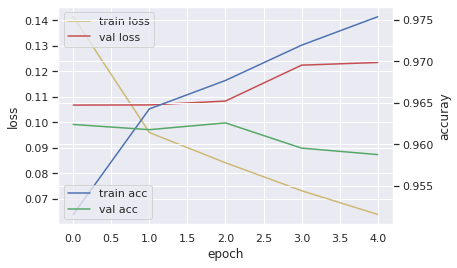

In [ ]:
# 5. 모델 학습 과정 표시하기 model2
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(model2.history['loss'], 'y', label='train loss')
loss_ax.plot(model2.history['val_loss'], 'r', label='val loss')

acc_ax.plot(model2.history['accuracy'], 'b', label='train acc')
acc_ax.plot(model2.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
train['comment_text2']=train['comment_text2'].str.split()

In [ ]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()
    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()
    # 전체 문서의 갯수
    total_docs = len(docs)
    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])
    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)
    wc = wc.sort_values(by='rank')
    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()
    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

wc = word_count(train['comment_text2'])
wc.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
96,article,36385,70805,1.0,0.013118,0.013118,0.228018
2,page,30870,54085,2.0,0.010020,0.023138,0.193456
10,talk,23018,31222,3.0,0.005784,0.028923,0.144249
131,one,21295,29526,4.0,0.005470,0.034393,0.133452
138,would,21148,29089,5.0,0.005389,0.039782,0.132530


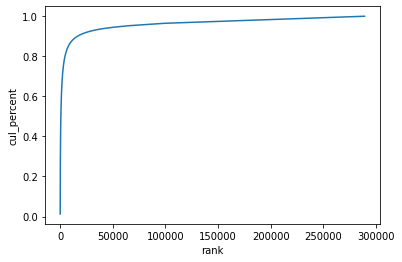

In [ ]:
sns.lineplot(x='rank', y='cul_percent', data=wc);

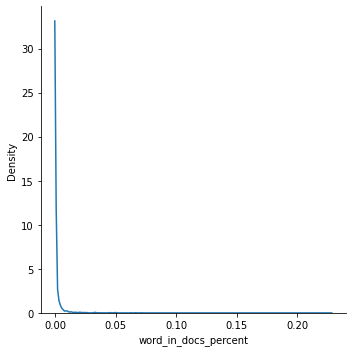

In [ ]:
sns.displot(wc['word_in_docs_percent'],kind='kde')

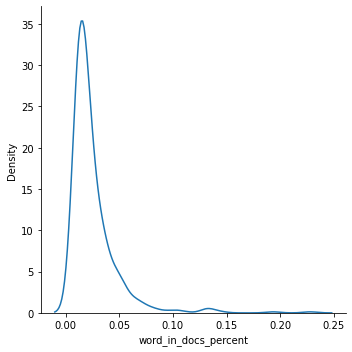

In [ ]:
wc = wc[wc['word_in_docs_percent'] >= 0.01]

sns.displot(wc['word_in_docs_percent'], kind='kde');

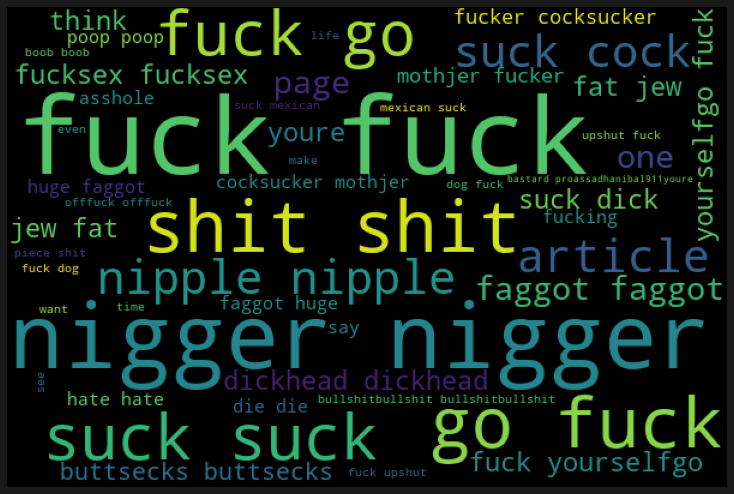

In [ ]:
#from wordcloud import WordCloud
#cloud = WordCloud(width=800, height=600).generate(' '.join(train['tokens']))

from wordcloud import WordCloud
hams = train['comment_text2'][train['rude']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
print(np.shape(embedding_matrix))


# 모델링2 - 악의적인 댓글 분류하기 ('mal')

0    144248
1     15323
Name: mal, dtype: int64


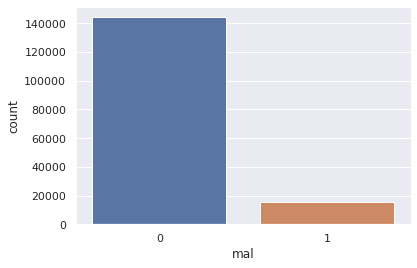

In [15]:
cols_target2 = ['malignant','highly_malignant','threat'] #3항목 중 하나라도 해당되면 악의적인 댓글(처벌이 필요한 댓글)
target_data = train[cols_target2]

train['mal'] =train[cols_target2].sum(axis =1)
#print(train['mal'].value_counts())
train['mal'] = train['mal'] > 0   #라벨링안되있으면 False 라벨링되있으면 True
train['mal'] = train['mal'].astype(int)  #라벨링안되있으면 0 라벨링되있으면 1
print(train['mal'].value_counts())

sns.set()
sns.countplot(x="mal" , data = train)   #악의적인 댓글은 전체 댓글의 10%
plt.show()

In [16]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use


list_sentences_train = train["comment_text2"].values
list_sentences_test = test["comment_text2"].values
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
x = pad_sequences(list_tokenized_train, maxlen=maxlen)
y=train['mal']
#x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.20)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((127656, 100), (127656,), (31915, 100), (31915,))

In [17]:
import tensorflow as tf
vocab_size = 20000
embedding_dim = 16
max_length = 100

model3 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 9606      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 329,613
Trainable params: 329,613
Non-trainable params: 0
_________________________________________________________________


In [18]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3 = model3.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val))

Epoch 1/10
3990/3990 [==============================] - 26s 6ms/step - loss: 0.1605 - accuracy: 0.9453 - val_loss: 0.1304 - val_accuracy: 0.9562
Epoch 2/10
3990/3990 [==============================] - 22s 6ms/step - loss: 0.1010 - accuracy: 0.9643 - val_loss: 0.1335 - val_accuracy: 0.9556
Epoch 3/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0734 - accuracy: 0.9740 - val_loss: 0.1465 - val_accuracy: 0.9549
Epoch 4/10
3990/3990 [==============================] - 22s 6ms/step - loss: 0.0469 - accuracy: 0.9840 - val_loss: 0.1791 - val_accuracy: 0.9538
Epoch 5/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0306 - accuracy: 0.9899 - val_loss: 0.2147 - val_accuracy: 0.9504
Epoch 6/10
3990/3990 [==============================] - 22s 6ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.2393 - val_accuracy: 0.9506
Epoch 7/10
3990/3990 [==============================] - 23s 6ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.2589 - val_ac

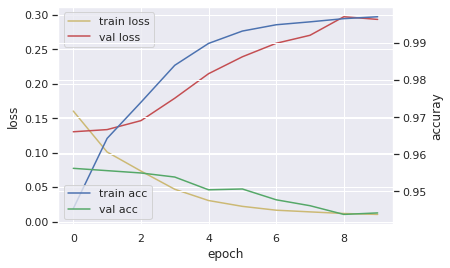

In [19]:
# 5. 모델 학습 과정 표시하기 model
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(model3.history['loss'], 'y', label='train loss')
loss_ax.plot(model3.history['val_loss'], 'r', label='val loss')

acc_ax.plot(model3.history['accuracy'], 'b', label='train acc')
acc_ax.plot(model3.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()